In [582]:
%reset -f  

In [583]:
import os, sys
import pandas as pd
import numpy as np
from IPython.display import display
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 100)
pd.options.display.precision = 4

sys.path.append(os.path.dirname(sys.path[0])) #to change to environment
from utils.constants import *

# visualization
import seaborn as sns       
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
%matplotlib inline

INPUT_FILE1 = "anonymous_080620_DA_translated.xlsx"
INPUT_FILE2 = "parsedData0.csv"
OUTPUT_FILE = "anonymous_080620_DA_parsed.xlsx"

In [584]:
# read anonymous
input_path = os.path.join(DPATH_ANONYMOUS, INPUT_FILE1)
df = pd.read_excel(input_path, sep=',')  

In [585]:
print(df.shape)

(1135, 14)


In [586]:
df.head()

,Code,Days of hospitalization,Sex,Age,Date of surgery,Patient classification,Name of surgery,Responsible surgeon,Urgency,Surgical approach,Complications,Kk,Simple,Severe
0,1135541,NaN,female,43.0,2018-03-12,Upper GI,OPEN DISTAL SUBTOTAL GASTRECTOMY 436320,NaN,elective,open,NaN,1.0,NaN,NaN
1,11341892,41.0,female,30.0,2018-03-13,upper GI,DIAGNOSTIC LAPAROSCOPY 493200;OPEN DISTAL SUBT...,NaN,urgent,LAPAROSCOPIC,Anastomotic Leak,1.0,NaN,1.0
2,11339133,NaN,male,26.0,2018-11-21,upper GI,EXPLORATORY LAPAROTOMY 490000;OPEN DISTAL SUBT...,NaN,urgent,open,Anastomotic Leak,1.0,1.0,NaN
3,11323824,11.0,female,62.0,2018-07-11,Upper GI,LAPAROSCOPIC REPAIR OF TRAUMATIC DIAPHRAGMATI...,Hazan David,urgent,LAPAROSCOPIC,NaN,1.0,NaN,NaN
4,11315215,NaN,NaN,NaN,2018-08-14,Upper GI,OPEN DISTAL SUBTOTAL GASTRECTOMY 436320; OPEN ...,NaN,elective,laparoscopic,Anastomotic Leak,1.0,1.0,NaN


### Drop duplicated rows

In [587]:
#down case "surgial approach" column
df['Surgical approach'] = df['Surgical approach'].str.lower()

There are 165 duplicate rows.

In [588]:
print("Num duplicated rows:", df.duplicated().sum())

Num duplicated rows: 165


In [589]:
#drop rows
df[df.duplicated()]
df.drop_duplicates(inplace=True)
print("Num current rows:", df.shape[0])

Num current rows: 970


## Drop patients who do not appear in events file

After droping duplicate rows and patients who don't appear in events file, **718** patients were left. 

In events file there are 680 patients. 

There are patients who underwent more than one surgery (hence 718 > 680) 

In [590]:
#read events file
events_path = os.path.join(DPATH_DATA, INPUT_FILE2)
events = pd.read_csv(events_path, sep=',') 

In [591]:
#get list of patients appearing in events files
pIDs = events["pid"].drop_duplicates()
pIDs.shape[0]

680

In [592]:
#drop patients who don't appear in list
df = df[df['Code'].isin(pIDs)]
df.shape

(718, 14)

### Parse date of surgery

In [593]:
#parse date     
df['Date of surgery'] = pd.to_datetime(df['Date of surgery'], format='%d/%m/%Y')

In [594]:
df['Date of surgery'].head()

0   2018-03-12
1   2018-03-13
2   2018-11-21
4   2018-08-14
5   2018-09-27
Name: Date of surgery, dtype: datetime64[ns]

In [595]:
df['Date of surgery'].describe()

count                     640
unique                    259
top       2018-07-04 00:00:00
freq                        7
first     2017-04-24 00:00:00
last      2019-07-10 00:00:00
Name: Date of surgery, dtype: object

### Info

In [596]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 718 entries, 0 to 1110
Data columns (total 14 columns):
Code                       718 non-null int64
Days of hospitalization    289 non-null float64
Sex                        353 non-null object
Age                        353 non-null float64
Date of surgery            640 non-null datetime64[ns]
Patient classification     718 non-null object
Name of surgery            718 non-null object
Responsible surgeon        248 non-null object
Urgency                    718 non-null object
Surgical approach          718 non-null object
Complications              165 non-null object
Kk                         717 non-null float64
Simple                     113 non-null float64
Severe                     91 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(1), object(7)
memory usage: 84.1+ KB


### Missing values

In [597]:
#pd.set_option('display.float_format', lambda x: '%.4f' % x)

# percentage of missing values in each column
percent_missing = df.isna().mean() * 100
percent_missing.to_frame(name="missing values (%)")

,missing values (%)
Code,0.0000
Days of hospitalization,59.7493
Sex,50.8357
Age,50.8357
Date of surgery,10.8635
Patient classification,0.0000
Name of surgery,0.0000
Responsible surgeon,65.4596
Urgency,0.0000
Surgical approach,0.0000


# Explore features

### **Describe numeric columns**

**Code** - Patient ID

**Days of hospitalization** - Number of days of hospitalization

**Age** - Age 

**Kk** - ? all values equal to 1. Can be removed.

**Simple & Severe** - Severity classification. See wikipedia. The columns "Simple" & "Severe" refer to this classification:

    Simple - under 3

    Severe - Above 3 inclusive - When the value '2' appears in this columns it is apparently a
    mistake. The columns 'Simple' & 'Severe' contain only indicator values 0 or 1 or only 1
    whenever relevant.

In [598]:
df.describe()

,Code,Days of hospitalization,Age,Kk,Simple,Severe
count,7.1800e+02,289.0000,353.0000,717.0,113.0,91.0000
mean,4.5604e+08,12.3253,53.4136,1.0,1.0,1.0110
std,2.7979e+08,15.1771,19.2857,0.0,0.0,0.1048
min,1.0684e+06,1.0000,16.0000,1.0,1.0,1.0000
25%,2.2858e+08,3.0000,39.0000,1.0,1.0,1.0000
50%,4.4233e+08,7.0000,55.0000,1.0,1.0,1.0000
75%,6.6846e+08,13.0000,68.0000,1.0,1.0,1.0000
max,1.0358e+09,108.0000,93.0000,1.0,1.0,2.0000


**Column: Code**

There are 680 patients.

In [599]:
df["Code"].nunique()

680

### **Sort by code and date of surgery**

In [600]:
#sort by patient ID
df.sort_values(by=['Code', 'Date of surgery'], inplace=True)

In [601]:
#reset index
df.reset_index(inplace=True, drop=True)

### Repeating patients 

Get pateints with more than 1 row.

There are 34 patients who underwent more than one surgery.  

In [602]:
s = df.groupby("Code").size().value_counts().to_frame(name="# patients")
s.index.name = "# surgeries"
s

,# patients
# surgeries,
1,646
2,30
3,4


In [603]:
#get patients with more than one surgery
df[df.groupby("Code")["Code"].transform('size') > 1];

#can also be coded thus:
#m = df.groupby('Code').size() > 1
#df[df['Code'].map(m)]

### **Describe object values**

**Sex** - Female/male.

**Date of Surgery** - Date of surgery in the format DD/MM/YYYY.

**Patient classification** - There are 10 classifications, see below. 

**Name of surgery** - Name and description of surgery, and some ID. 

**Responsible surgeon** - Name of responsible surgeon. 
    
**Urgency** - Two values: urgency / elective.  

**Surgical approach** - Three values: open / laparoscopic / Robotic surgery
    
**Complications** - Description of complications, including 'Anastomotic Leak' 

In [604]:
df.describe(include= ['object'])

,Sex,Patient classification,Name of surgery,Responsible surgeon,Urgency,Surgical approach,Complications
count,353,718,718,248,718,718,165
unique,2,17,313,17,2,3,90
top,female,Bariatric,LAPAROSCOPIC SLEEVE GASTRECTOMY 438430,Nissan Aviram,elective,laparoscopic,Anastomotic Leak
freq,203,244,104,63,535,378,58


### **Column: Date of surgery**

In [605]:
df[["Date of surgery"]].dropna().head()

,Date of surgery
1,2018-07-18
2,2018-09-25
3,2018-09-22
4,2018-03-12
5,2018-05-22


 Dates of surgeries: **2017-04-24** until **2019-07-10**. 
 - Need to fill the missing values.
 - In half of the days, there is more than one surgery. Is it possible that there are 7 surgerys a day?

In [606]:
df["Date of surgery"].describe()

count                     640
unique                    259
top       2018-07-04 00:00:00
freq                        7
first     2017-04-24 00:00:00
last      2019-07-10 00:00:00
Name: Date of surgery, dtype: object

In [607]:
#number of surgeries a day
df["Date of surgery"].value_counts().describe()

count    259.0000
mean       2.4710
std        1.6001
min        1.0000
25%        1.0000
50%        2.0000
75%        3.0000
max        7.0000
Name: Date of surgery, dtype: float64

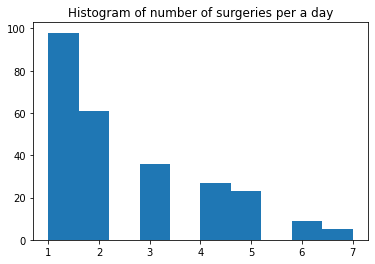

In [608]:
plt.hist(df["Date of surgery"].value_counts());
plt.title("Histogram of number of surgeries per a day");

**Column: Patient classification**

There are 10 classes:
    1.	Appendectomy
    2.	Bariatric
    3.	Colorectal
    4.	Emergency
    5.	Hernia
    6.	Hpb
    7.	Other
    8.	Small Bowel
    9.	Surgical Oncology
    10.	Upper Gi


In [609]:
df["Patient classification"].nunique()

17

In [610]:
df["Patient classification"].value_counts()

Bariatric            244
Colorectal           187
Surgical Oncology    126
Hernia                50
small bowel           28
Emergency             21
Small Bowel           11
hernia                 9
colorectal             9
bariatric              8
Upper GI               7
Other                  6
Small bowel            6
upper GI               2
HPB                    2
Appendectomy           1
other                  1
Name: Patient classification, dtype: int64

In [611]:
#unit classes differ in capital letters 
df["Patient classification"] = df["Patient classification"].str.title()

In [612]:
#number of unique values for each classification
df["Patient classification"].value_counts().rename_axis('Patient classifications').to_frame('counts')


,counts
Patient classifications,
Bariatric,252
Colorectal,196
Surgical Oncology,126
Hernia,59
Small Bowel,45
Emergency,21
Upper Gi,9
Other,7
Hpb,2


### **column: Name of surgery**

Names are quiet long. They should be classified into several classes. 

In [613]:
df["Name of surgery"].nunique()

313

In [614]:
df[["Name of surgery"]].drop_duplicates()

,Name of surgery
0,DIAGNOSTIC/ STAGING LAPAROSCOPY 493200;LAPAROS...
1,CYTOREDUCTIVE SURGERY WITH HIPEC (HYPERTHERMIC...
2,LAPAROSCOPIC CHOLECYSTECTOMY 475620; LAPAROSCO...
3,"OPEN TOTAL GASTRECTOMY, WITH ESOPHAGOENTEROSTO..."
4,OPEN DISTAL SUBTOTAL GASTRECTOMY 436320
...,...
713,APPENDECTOMY;CYTOREDUCTIVE SURGERY WITH HIPEC ...
714,"ABDOMINAL HYSTERECTOMY, TOTAL WITH BSO (T.A.H ..."
715,CYTOREDUCTIVE SURGERY WITH HIPEC (HYPERTHERMIC...
716,CYTOREDUCTIVE SURGERY WITH HIPEC (HYPERTHERMIC...


### **column: Responsible surgeon**

In [615]:
surgeonsNames = df["Responsible surgeon"].value_counts()
surgeonsNames

Nissan Aviram             63
Hermon Hila               46
Goitman David             32
Segev Lior                29
                          16
Ben-Yaakov Almog          15
Hazan David               15
Vestrich Gali             10
Feigin Ania                5
Zippel Dov                 4
Wexler-Feigin Ania         2
Nevo Jonathan              2
Cohen Amir                 2
Ashkenazi Roni             2
Klein Yorm                 2
Friedman Orly-Zipporah     2
Berger Yaniv               1
Name: Responsible surgeon, dtype: int64

### **column: Urgency**

There are 535 elective surgeries.

In [616]:
df["Urgency"].value_counts().rename_axis('urgency').to_frame('counts')

,counts
urgency,
elective,535
urgent,183


There are 15 patients who underwent both elective and urgent surgeries.

In [617]:
df[df.groupby("Code")["Urgency"].transform('nunique') > 1].groupby("Code").ngroups

15

### **column: Surgical approach**

 There are 3 approaches:
    1.	Open
    2.	Laparoscopic
    3.	Robotic surgery

In [618]:
df["Surgical approach"].value_counts().rename_axis('approaches').to_frame('counts')

,counts
approaches,
laparoscopic,378
open,339
robotic surgery,1


### **column: Complications**

In [619]:
df["Complications"].nunique()

90

In [620]:
df["Complications"].value_counts().rename_axis('complications').to_frame('counts').head()

,counts
complications,
Anastomotic Leak,58
Skin and soft tissue - SSI- Superficial - 1,7
Gastrointestinal - lleus - 1,5
SSI- Superficial: 1,4
Cardiac - Cardiac arrhythmia - 2,3


# **Anastomotic Leak** 
There are 58 patients with anastomotic leak.

In [621]:
anastomoticLeak = df[df["Complications"] == "Anastomotic Leak"]
anastomoticLeak.shape

(58, 14)

In [622]:
anastomoticLeak;

### Fill missing values 

Fill the sex of patients with known sex

In [623]:
df["Sex"] = df.groupby("Code")["Sex"].fillna(method="pad")

# Write output

In [624]:
#rename code column to "pid" (as it called in events file)
df.rename(columns={"Code": "pid"}, inplace=True)

output_path = os.path.join(DPATH_ANONYMOUS, OUTPUT_FILE)
if not os.path.exists(output_file):
    with pd.ExcelWriter(output_path, datetime_format='DD/MM/YYYY') as writer:
        df.to_excel(writer, index =False)

NameError: name 'output_file' is not defined